In [ ]:
# This takes amplitudes of fake companions made to be 5-sigma above the noise,
# where sigma is the stdev of the smoothed noise annulus at that radius from the host star

# Created 2020 Mar 19 by E.S.

In [ ]:
# INPUT: list of 
# 1.) Angular distance from host star (asec)
# 2.) Linearly-scaled contrast (i.e., ratio of amplitudes between a fake planet and the host star;
#       0.01 means '0.01 of host star amplitude'). These contrasts are those at which a fake planet
#       has an amplitude such that the signal-to-noise is 5

# OUTPUT: list of
# 1.) Angular distance from host star (asec)
# 2.) Threshold 

In [ ]:
# Ref: Research journal, 2020 Mar 21

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

import matplotlib.pyplot as plt

In [10]:
original_contrast_curve = pd.read_csv("data/fake_contrast_curve.csv")

In [11]:
# Set some initial constants

# Note that radii are all in units of FWHM unless explicity
# stated otherwise

#### $N_{FP}^{(tot)}=0.01$
#### $R_{max}=20$

In [12]:
N_FP_tot = 0.01
R_max = 20

In [13]:
# Then at each radius we have a constant 

#### $N_{FP}=N_{FP}^{(tot)}/R_{max}$

In [15]:
N_FP = np.divide(N_FP_tot,R_max)

In [ ]:
# And thus the FPF is a function of radius:

#### $FPF(r)=\frac{N_{FP}}{2\pi r}$

In [16]:
def FPF_r(r):
    
    return np.divide(N_FP,2*np.pi*r)

In [17]:
# Under the hypothesis H0, the FPF(r) is

#### $FPF(r)=\int_{\tau}^{\infty}p_{t}(x,n_{2}-1)dx |_{r}$

In [ ]:
# This means that tau is where the CDF is 1-FPF (DOFs implied):

#### $CDF(\tau)=1-FPF(r)$

In [18]:
# To find tau, invert the CDF:

#### $\frac{\tau(r)}{\bar{s}(r)}=C_{st}^{-1}(1-FPF(r)|n-1)$

In [ ]:
# Now, under the hypothesis H1, consider a fixed $TPF$.

#### $TPF(r) = \int_{\mu_{c}-\tau}^{\infty}p_{t}(x,n_{2}-1)dx |_{r}$

In [ ]:
# Inverting, rearranging, and substituting, we have

#### $\frac{\mu_{c}(r)}{\bar{s}(r)} = C_{st}^{-1}(1-FPF(r)|n-1) + C_{st}^{-1}(TPF|n-1)$

In [ ]:
mean, var, skew, kurt = t.stats(df, moments='mvsk')

In [ ]:
ppf(q, df, loc=0, scale=1)

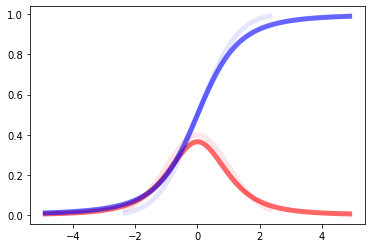

In [32]:
df = 2.74335149908
fig, ax = plt.subplots(1, 1)

mean, var, skew, kurt = t.stats(df, moments='mvsk')
x = np.linspace(t.ppf(0.01, df),t.ppf(0.99, df), 100)
ax.plot(x, t.pdf(x, df),'r-', lw=5, alpha=0.6, label='t pdf')
ax.plot(x, t.cdf(x, df),'b-', lw=5, alpha=0.6, label='t cdf')

df = 1000

mean, var, skew, kurt = t.stats(df, moments='mvsk')
x = np.linspace(t.ppf(0.01, df),t.ppf(0.99, df), 100)
ax.plot(x, t.pdf(x, df),'r-', lw=5, alpha=0.1, label='t pdf')
ax.plot(x, t.cdf(x, df),'b-', lw=5, alpha=0.1, label='t cdf')

In [ ]:
# The fake injected planets are of amplitude N*sbar,
# so just divide those amplitudes by N (which is probably 5).

# The contrast level 'corrected' for small angles is then 

#### $\mu_{c}(r) = \bar{s}(r)\left[C_{st}^{-1}(1-FPF(r)|n-1) + C_{st}^{-1}(TPF|n-1)\right]$